# Analysis: Moments

This notebook outlines the approach taken to generate the `moment` feature in the win probability plot. For the rest of this notebook, the definition of the `moment` of a Starcraft 2 game will be as follows:

<b>Moment<b>
: The moment consists of three pieces of information
    
    1) Moment Index: The points t0 and t` where the largest monotonic shift in win probability occurs.
    
    2) Moment Feature: The feature most responsible for the shift in win probability between t0 and t1.
    
    3) Moment Feature Change: The change in the moment feature between t0 and t1.
    
The main goal of `moments` is to be able to highlight large changes in the win probability, and identify the feature most responsible for driving such a change. This allows us to gain insights into what is happening during the game while only looking at the win probability plot. The solution relies on using [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) as an explainability framework for the underlying XGBoost model.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import starcraft_predictor as scp

## Step 1: Calculate the Moment Index

The first step to the process is to be able to identify where the shifts in probability are happening. To do this, we hunt for all local maxima and minima points within the predictions array. Once these points are located, we can construct line segments for these points, as demonstrated in *figure_1*:

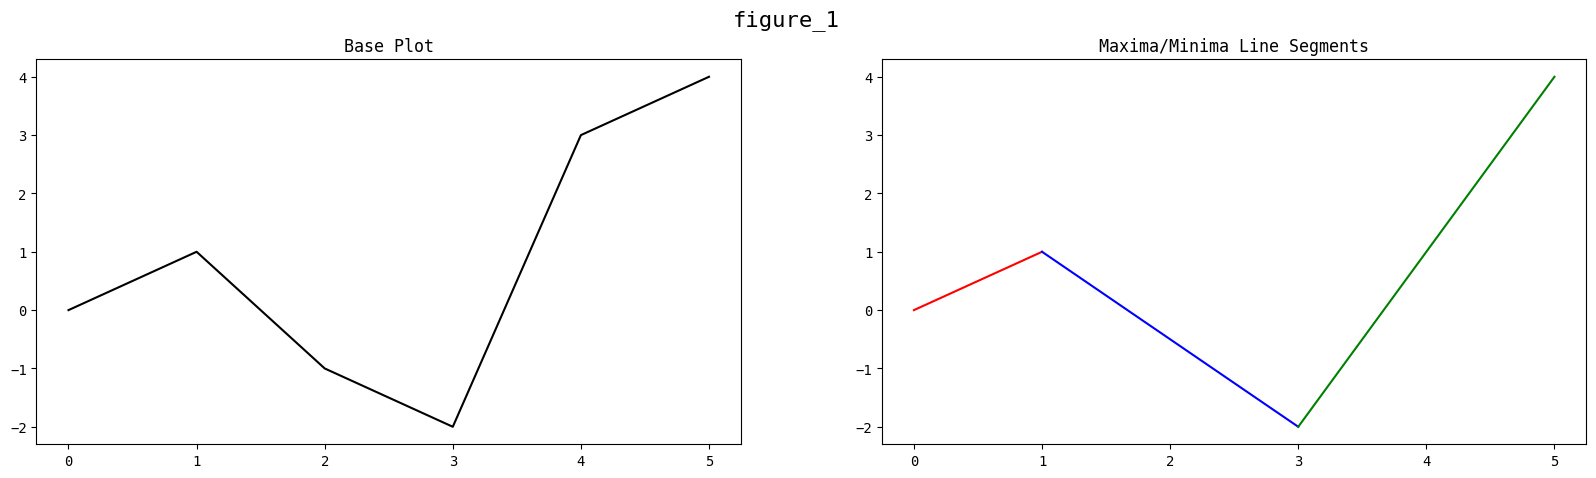

In [4]:
# note: all plotting functions are defined in the appendix below and will not run in order.
plot_figure_1()

The change in y can then be calculated, and the largest change can be identified as the location of the `moment index`. The moment index for the example above would be [3, 5] (the green line). There are two caveats to the approach shown above:
1) The change must be monotonic. A noisy probability plot, even if demonstrating a trend, will not accurately capture the `moment`. This problem will hopefully be minimised by prediction smoothing.

2) The `moment` has no consideration for rate of change. A short, sharp change will not be considered as the `moment` if a much longer, monotonic trend occurs in the game that has a larger overall change in probability. This could result in the selected `moment` not being the most defining change in the game.

## Step 2: Calculating the Moment Feature

Once the `moment index` has been identified, we can begin to hunt for the `moment feature`. To do this, we will use shapley values to assess feature contribution at both `t0` and `t1`. The following process is undertaken to find the `moment feature`:

1) Generate Shapley values for the replay at `t0` and `t1`

2) For each feature, calculate the difference in Shapley value between `t0` and `t1`

3) Identify the feature with the maximum absoluate Shapley difference.

*figure_2* shows a visual representation of the change in Shapley values between two points `t0` and `t1`:

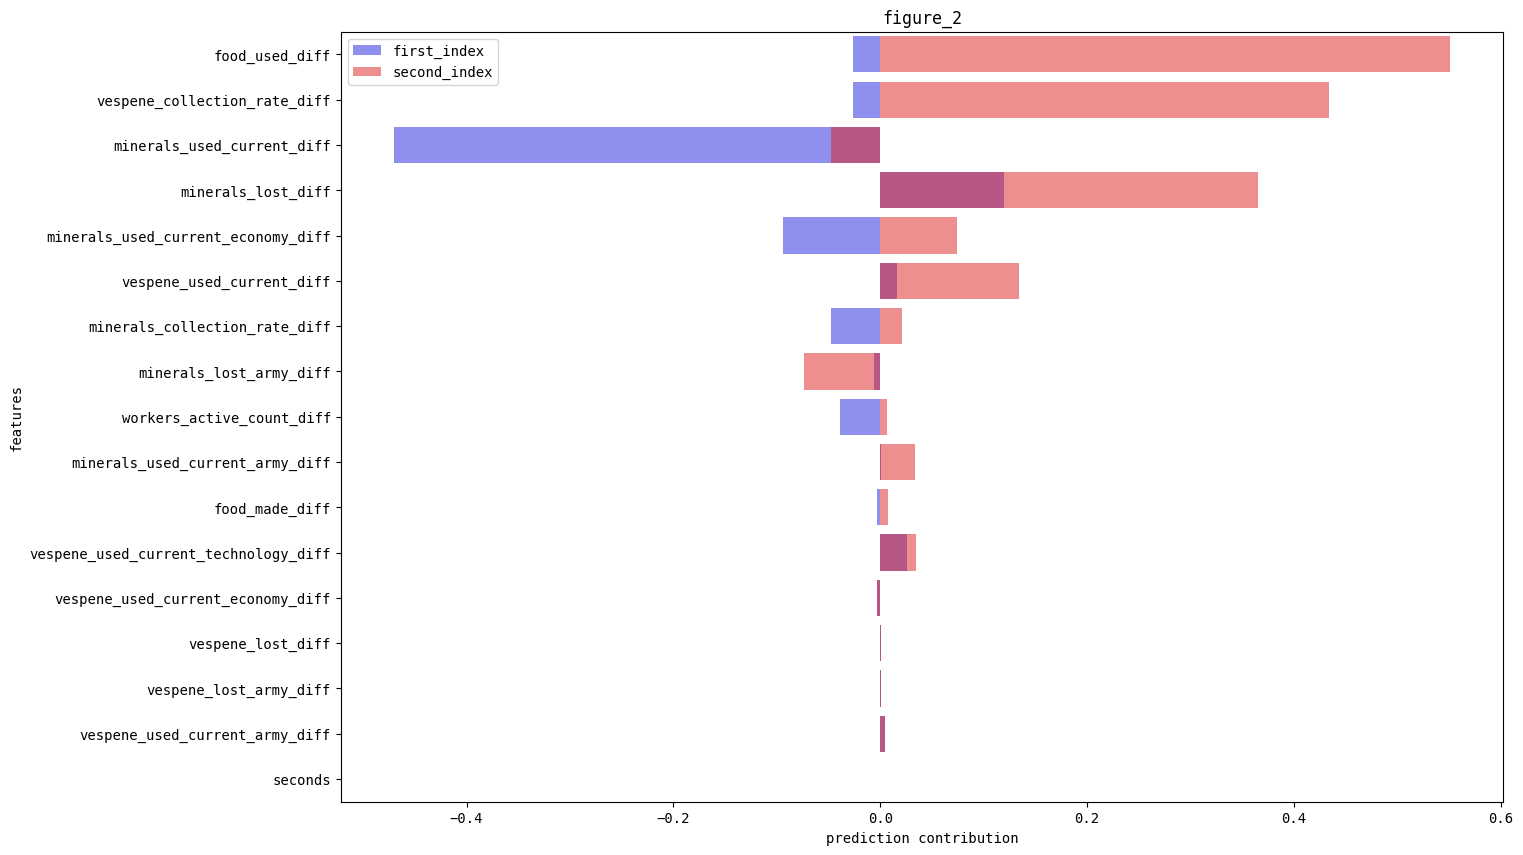

In [5]:
plot_figure_2()

*figure_2* shows the change in contribution of each feature between two points `t0` and `t1`. For a given feature, the blue bar represents that features contribution at game time `t0`. The red bar represents that features contribution at game time `t1`. The gap between the end of the blue bar and the end of the red bar represents the change in feature contribution. The plot is sorted with the largest change at the top, and the smallest change at the bottom. In the example above `food_used_diff` is the `moment feature`.

## Step 3: Calculate the Moment Feature Change

The next step is simple. To calculate the `moment feature change` we simply calculate the `moment feature` value at `t0` and `t1` and subtract the values. Now we have all three compononents of the `moment` and the information can be added to the plot. The `moment` for the example replay in `starcraft_predictor/example_data/example_replay.SC2Replay` is:

- Moment Index: `[70, 84]`

- Moment Feature: `food_used_diff`

- Moment Feature Change: `31.0`

## Plotting

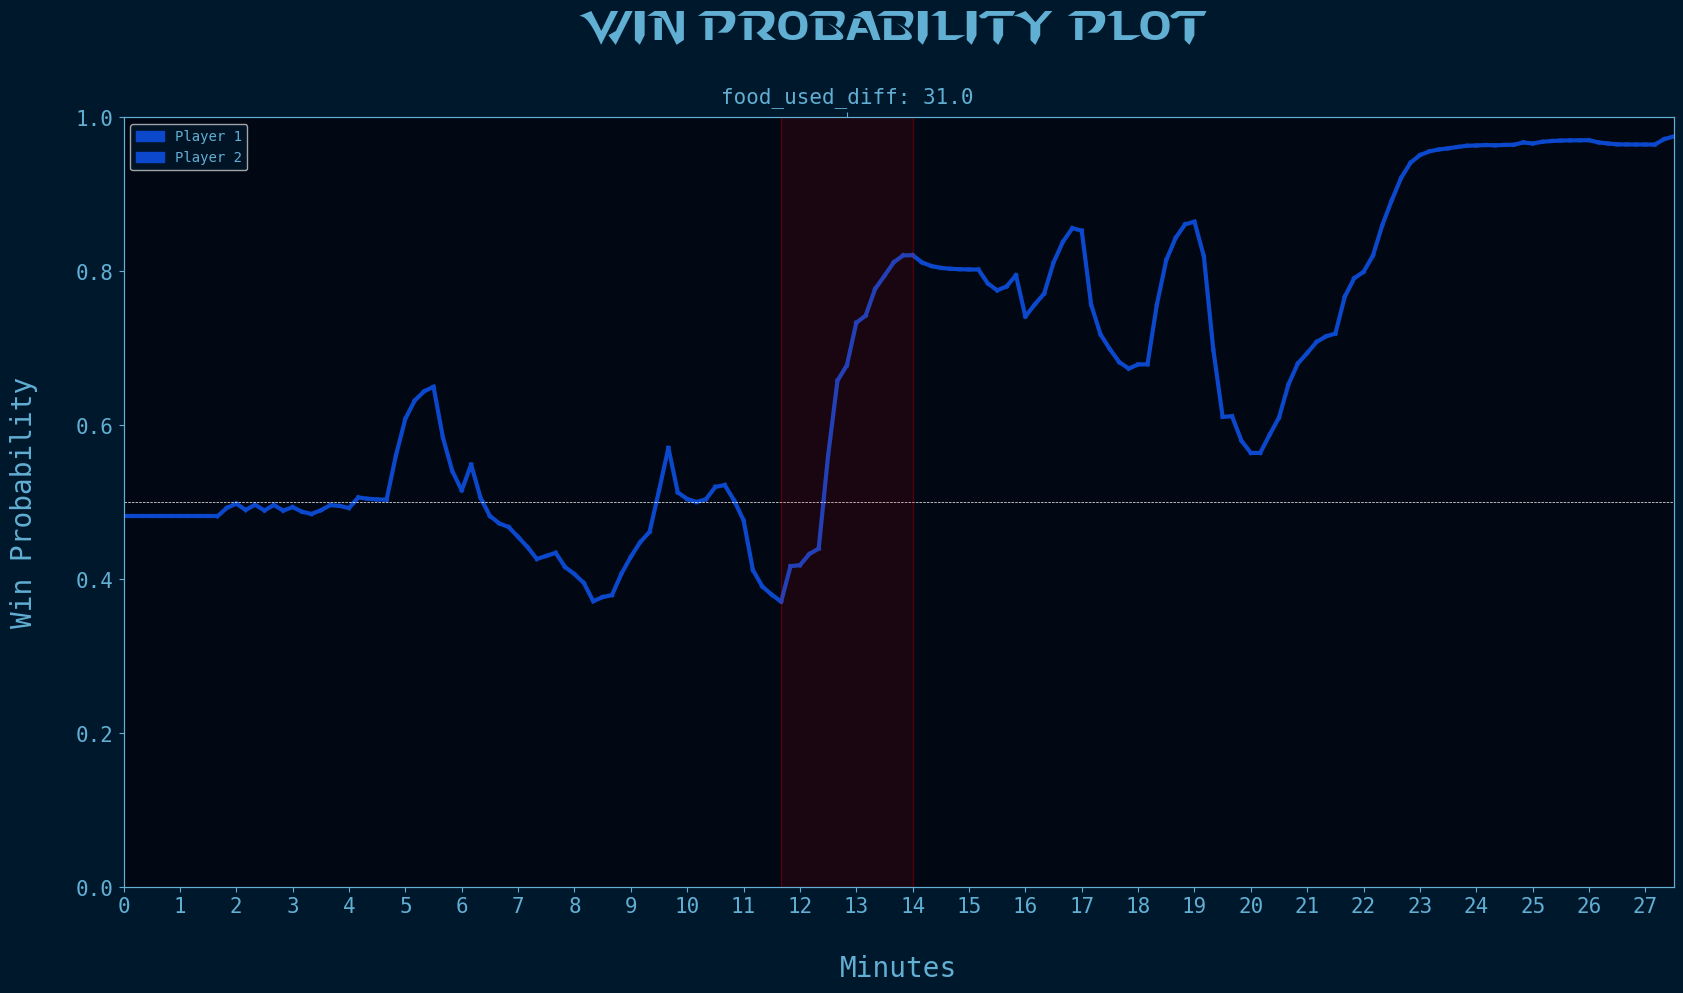

In [6]:
scp.api.evaluate_replay("../example_data/example_replay.SC2Replay", moment=True)

## Appendix

In [2]:
def plot_figure_1():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    sns.lineplot(x=[0, 1, 2, 3, 4, 5], y=[0, 1,-1, -2, 3, 4], ax=ax[0], color="black")
    sns.lineplot(x=[0, 1], y=[0, 1], ax=ax[1], color="red")
    sns.lineplot(x=[1, 3], y=[1, -2], ax=ax[1], color="blue")
    sns.lineplot(x=[3, 5], y=[-2, 4], ax=ax[1], color="green")
    ax[0].set_title("Base Plot")
    ax[1].set_title("Maxima/Minima Line Segments")
    fig.suptitle('figure_1', fontsize=16)
    plt.show()

In [3]:
def plot_figure_2():
    
    replay = scp.api._load_replay("../example_data/example_replay.SC2Replay")
    processed_replay = scp.api._process_replay(replay)
    predictions = scp.api._generate_predictions(processed_replay)
    features = scp.starcraft_model.params.FEATURES
    
    sc_shap = scp.StarcraftShap(
        processed_replay=processed_replay,
        features=features,
        predictions=predictions,
        model=scp.starcraft_model.model,
    )
    
    moment_index = sc_shap._get_moment_index()
    shap_values = sc_shap._get_shap_values()
    
    # generate plotting dataframe
    plotting_dataframe = pd.DataFrame({
        "features": features,
        "first_index": shap_values[moment_index[0]],
        "second_index": shap_values[moment_index[1]],
        "abs_difference": abs(shap_values[moment_index[0]] - shap_values[moment_index[1]])
    })
    
    plotting_dataframe.sort_values("abs_difference", ascending=False, inplace=True)
    plotting_dataframe.reset_index(inplace=True, drop=True)
    
    # plot the feature contribution for each index
    fig, ax = plt.subplots(figsize=(15,10))

    sns.barplot(
        y=plotting_dataframe["features"],
        x=plotting_dataframe["first_index"],
        color="blue",
        alpha=0.5,
        label="first_index",
    )
    sns.barplot(
        y=plotting_dataframe["features"],
        x=plotting_dataframe["second_index"],
        color="red",
        alpha=0.5,
        label="second_index",
    )
    
    plt.xlabel("prediction contribution")
    plt.title("figure_2")
    plt.legend()
    plt.show()